# Explore raw data


In [1]:
# Standard libraries
from pathlib import Path    

# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Network analysis
import networkx as nx
import netbone as nb
import igraph as ig

# Source code
from src.utils import data_explorer as dx
from src.utils import viz
from src.data_prep import data_prep 

# Misc
from IPython.display import display
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

%load_ext autoreload
%autoreload 2

Can't load ECM Model in windows, try using it on linux


## Load data


In [2]:
# Load data
data = pd.read_parquet("data/clean/bills_sponsors.parquet")

## Inspect


In [3]:
# Inspect
dx.summarize_df(data, verbose=True)

,bioguide_id,first_name,last_name,party,state,district,sponsor_type,congress,bill_type,bill_number,origin_chamber,policy_area,title,introduced_date,bill_id,sponsor_title,sponsor_id
0,Y000031,C. W.,Young,R,FL,10,sponsor,108,hjres,114,house,economics and public finance,Making further continuing appropriations for t...,2004-11-19,108_hjres_114,Rep,Y000031_R_FL_Rep


{'basic': {'rows': 1671005,
           'cols': 17,
           'memory_usage_mb': 232.66,
           'n_bool_cols': 0,
           'n_numeric_cols': 2,
           'n_object_cols': 0,
           'n_datetime_cols': 1},
 'dtypes': {'bioguide_id': string[python],
            'first_name': string[python],
            'last_name': string[python],
            'party': string[python],
            'state': string[python],
            'district': string[python],
            'sponsor_type': string[python],
            'congress': Int64Dtype(),
            'bill_type': string[python],
            'bill_number': Int64Dtype(),
            'origin_chamber': string[python],
            'policy_area': string[python],
            'title': string[python],
            'introduced_date': dtype('<M8[ns]'),
            'bill_id': string[python],
            'sponsor_title': string[python],
            'sponsor_id': string[python]},
 'examples': {'bioguide_id': 'W000822',
              'first_name': 'Bonnie',
 

- 1.67M rows.
- Each row of the data is a sponshorship of a bill by a legislator (an activity)
- Columns with missing values: `district` (17%), `policy_area` (0.27%)


## Bills


In [4]:
# Subset bills
bill_cols = [
    "bill_id",
    "bill_type",
    "bill_number",
    "congress",
    "origin_chamber",
    "policy_area",
    "title",
    "introduced_date",
]

bills = data[bill_cols].drop_duplicates().reset_index(drop=True)
dx.summarize_df(bills)

Shape: (128775, 8)


,bill_id,bill_type,bill_number,congress,origin_chamber,policy_area,title,introduced_date
0,108_hjres_114,hjres,114,108,house,economics and public finance,Making further continuing appropriations for t...,2004-11-19


In [5]:
# Unique bills
print("N unique bills: ", bills["bill_id"].nunique())

N unique bills:  128775


- 129K bills, no duplicates


In [6]:
# By chamber
bills["origin_chamber"].value_counts(normalize=True) * 100

origin_chamber
house     64.441079
senate    35.558921
Name: proportion, dtype: Float64

- 64% from House, 36% from Senate


In [7]:
# By chamber and type
bills.groupby("origin_chamber")["bill_type"].value_counts(normalize=True) * 100

origin_chamber  bill_type
house           hr           98.345464
                hjres         1.654536
senate          s            98.573956
                sjres         1.426044
Name: proportion, dtype: float64

- No bill in wrong chamber
- In House, majority is `hr` (98%)
- In Senate, majority is `s` (97%)


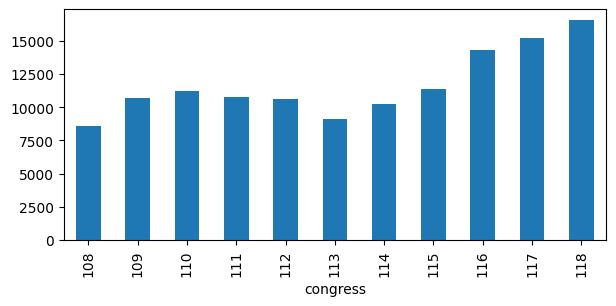

In [8]:
# Bills by congress
bills["congress"].value_counts().sort_index().plot(kind="bar", figsize=(7, 3))
plt.show()

- Num bills has increased over since 113th congress (double in 118th congress)


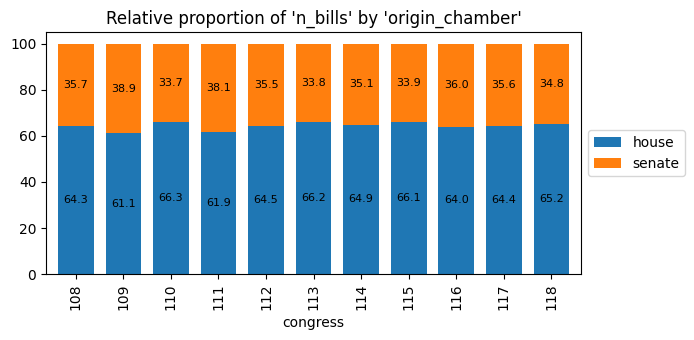

In [9]:
# Bill composition by chamber over time
tmp = bills.groupby(["congress", "origin_chamber"]).size().reset_index(name="n_bills")
viz.plot_relative_proportion(tmp, x="congress", y="n_bills", hue="origin_chamber")

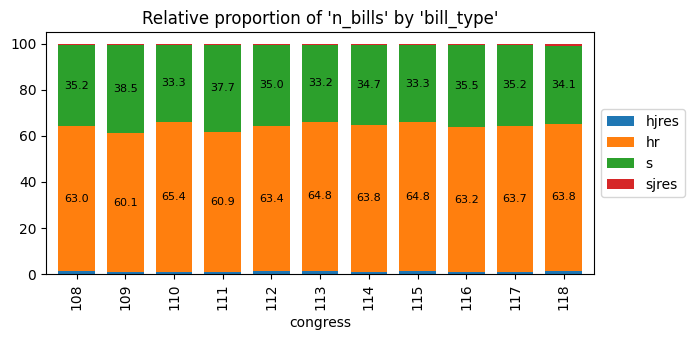

In [10]:
# Bill composition by chamber and type over time
tmp = bills.groupby(["congress", "bill_type"]).size().reset_index(name="n_bills")
viz.plot_relative_proportion(tmp, x="congress", y="n_bills", hue="bill_type")

- Bill composition by chamber and bill type over time is relatively stable
  - By chamber: 64% House, 36% Senate
  - By type: 64% `hr`, 35% `s`, others negligible


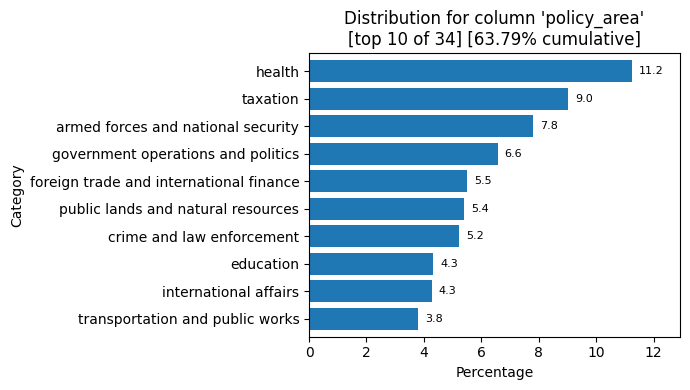

In [11]:
# Policy areas
dx.summarize_categorical_col(bills, "policy_area")

- 34 policy areas, with top 10 accounting for 64% of bills


## Sponsors


In [12]:
sponsor_cols = [
    "sponsor_id",
    "bioguide_id",
    "party",
    "state",
    "sponsor_title",
    "first_name",
    "last_name",
]

sponsors = data[sponsor_cols].drop_duplicates().reset_index(drop=True)
sponsors.head(1)

,sponsor_id,bioguide_id,party,state,sponsor_title,first_name,last_name
0,Y000031_R_FL_Rep,Y000031,R,FL,Rep,C. W.,Young


In [13]:
# Check sponsors with duplicates biooguide id
tmp = sponsors["bioguide_id"].value_counts()
tmp[tmp > 1].head()

bioguide_id
M001159    3
S001191    3
A000367    3
D000618    2
C001047    2
Name: count, dtype: Int64

In [14]:
# Inspect M001159
sponsors[sponsors["bioguide_id"] == "M001159"]

,sponsor_id,bioguide_id,party,state,sponsor_title,first_name,last_name
576,M001159_R_WA_Rep,M001159,R,WA,Rep,Cathy,Mcmorris
593,M001159_R_WA_Rep,M001159,R,WA,Rep,Cathy,Mcmorris Rodgers
1232,M001159_R_WA_Rep,M001159,R,WA,Rep,Cathy,Rodgers


- This person's last name was not consistently recorded
- Proposed solution:
  - Create a unique df of `bioguide_id`, `first_name`, `last_name`
  - Drop `first_name` and `last_name` from the main df
  - Join the unique df to the main df on `bioguide_id`
- This fix will be implemented in data prep pipeline for consistency across future use cases


In [15]:
# Remove first name and last time and check duplicate reasons for other cases
drop_cols = ["first_name", "last_name"]
tmp = sponsors.drop(columns=drop_cols).drop_duplicates()
tmp = tmp["bioguide_id"].value_counts()
tmp[tmp > 1].head()

bioguide_id
A000367    3
S001191    3
M001190    2
R000608    2
W000437    2
Name: count, dtype: Int64

In [16]:
# Inspect A000367
sponsors[sponsors["bioguide_id"] == "A000367"]

,sponsor_id,bioguide_id,party,state,sponsor_title,first_name,last_name
787,A000367_R_MI_Rep,A000367,R,MI,Rep,Justin,Amash
1227,A000367_L_MI_Rep,A000367,L,MI,Rep,Justin,Amash
1244,A000367_I_MI_Rep,A000367,I,MI,Rep,Justin,Amash


- This person change their party affiliation over time (valid reason) and there is no need to fix this
- We will remove those `sponsor_id`, `party`, `first_name`, `last_name` and continue to check for duplicates


In [17]:
drop_cols = ["sponsor_id", "party", "first_name", "last_name"]
tmp = sponsors.drop(columns=drop_cols).drop_duplicates()
tmp = tmp["bioguide_id"].value_counts()
tmp[tmp > 1].head()

bioguide_id
M001169    2
I000055    2
B001230    2
M001197    2
M000934    2
Name: count, dtype: Int64

In [18]:
sponsors[sponsors["bioguide_id"] == "M001169"].drop_duplicates()

,sponsor_id,bioguide_id,party,state,sponsor_title,first_name,last_name
620,M001169_D_CT_Rep,M001169,D,CT,Rep,Christopher,Murphy
987,M001169_D_CT_Sen,M001169,D,CT,Sen,Christopher,Murphy


- This person moved from the House to the Senate at some point (valid reason)
- We will drop `sponsor_title` as well and continue to check for duplicates


In [19]:
drop_cols = ["sponsor_id", "party", "sponsor_title", "first_name", "last_name"]
tmp = sponsors.drop(columns=drop_cols).drop_duplicates()
tmp = tmp["bioguide_id"].value_counts()
tmp[tmp > 1].head()

Series([], Name: count, dtype: Int64)

- No more duplicates found
- Now we only need to fix the issue caused by inconsistency in sponsor names


In [20]:
name_df = sponsors[["bioguide_id", "first_name", "last_name"]].drop_duplicates(
    subset=["bioguide_id"]
)

data = data.drop(columns=["first_name", "last_name"]).merge(name_df, on="bioguide_id")

sponsors = sponsors.drop(columns=["first_name", "last_name"]).merge(
    name_df, on="bioguide_id"
)

In [21]:
# Double check M001159
sponsors[sponsors["bioguide_id"] == "M001159"]

,sponsor_id,bioguide_id,party,state,sponsor_title,first_name,last_name
576,M001159_R_WA_Rep,M001159,R,WA,Rep,Cathy,Mcmorris
593,M001159_R_WA_Rep,M001159,R,WA,Rep,Cathy,Mcmorris
1232,M001159_R_WA_Rep,M001159,R,WA,Rep,Cathy,Mcmorris


In [22]:
print("N rows: ", sponsors.shape[0])
print("N unique bioguide_id:", sponsors["bioguide_id"].nunique())

N rows:  1448
N unique bioguide_id: 1369


- 1448 rows, 1369 unique bioguide_id (duplicated bioguide_id was due to changing party, chamber, or title)


In [23]:
# Check if there is legislator in wrong chamber
data.groupby("origin_chamber")["sponsor_title"].value_counts(normalize=True) * 100

origin_chamber  sponsor_title
house           Rep               98.353244
                Del                1.461516
                Res                0.185168
                Sen                0.000072
senate          Sen              100.000000
Name: proportion, dtype: float64

- Senate has no issue (100% `Sen` title)
- In House, majority is `Rep` (98%)
- There is an issue where `Sen` appears in House


In [24]:
# Find the wrong Sen in House
data[(data["origin_chamber"] == "house") & (data["sponsor_title"] == "Sen")]

,bioguide_id,party,state,district,sponsor_type,congress,bill_type,bill_number,origin_chamber,policy_area,title,introduced_date,bill_id,sponsor_title,sponsor_id,first_name,last_name
505223,K000360,R,IL,<NA>,sponsor,111,hr,6448,house,government operations and politics,Spending Control Act of 2010,2010-11-29,111_hr_6448,Sen,K000360_R_IL_Sen,Mark,Kirk


In [25]:
# Check the person's activity
(
    data[data["bioguide_id"] == "K000360"]
    .groupby(["origin_chamber"])["sponsor_title"]
    .value_counts()
)

origin_chamber  sponsor_title
house           Rep              899
                Sen                1
senate          Sen              732
Name: count, dtype: int64

- A quick check on bioguide for `bioguide_id = K000360` reveals that this is [KIRK, Mark Steven](https://bioguide.congress.gov/search/bio/K000360), and in 111th congress, he moved from House to Senate on Nov 29, 2010.
- Proposed fix:
  - Change `sponsor_title` to `Rep` for every House bill with `Sen` title
  - Regenerate `sponsor_id` since they are based on `sponsor_title`
  - This fix should also be implemented in data prep pipeline


In [26]:
# Fix sponsor title
cond = (data["origin_chamber"] == "house") & (data["sponsor_title"] == "Sen")
col = "sponsor_title"

data.loc[cond, col] = "Rep"
sponsors.loc[cond, col] = "Rep"

data["sponsor_id"] = data_prep._create_sponsor_id(
    data["bioguide_id"],
    data["party"],
    data["state"],
    data["sponsor_title"],
)

sponsors["sponsor_id"] = data_prep._create_sponsor_id(
    sponsors["bioguide_id"],
    sponsors["party"],
    sponsors["state"],
    sponsors["sponsor_title"],
)

In [27]:
# Double check
data.groupby("origin_chamber")["sponsor_title"].value_counts(normalize=True) * 100

origin_chamber  sponsor_title
house           Rep               98.353316
                Del                1.461516
                Res                0.185168
senate          Sen              100.000000
Name: proportion, dtype: float64

- Now all legislators have consistent titles with their chamber


In [28]:
# Number of sponsors by chamber over time
(
    data.groupby(["origin_chamber", "sponsor_title", "congress"])["sponsor_id"]
    .nunique()
    .unstack()
)

congress                      108  109  110  111  112  113  114  115  116  \
origin_chamber sponsor_title                                                
house          Del              4    4    4    5    5    5    5    5    5   
               Rep            441  440  447  446  444  441  440  447  445   
               Res              1    1    1    1    1    1    1    1    1   
senate         Sen            100  101  102  110  101  105  100  105  102   

congress                      117  118  
origin_chamber sponsor_title            
house          Del              5    5  
               Rep            448  445  
               Res              1    1  
senate         Sen            100  104

- The composition of legislators by chamber and title is consistent over time (obviously, by design).


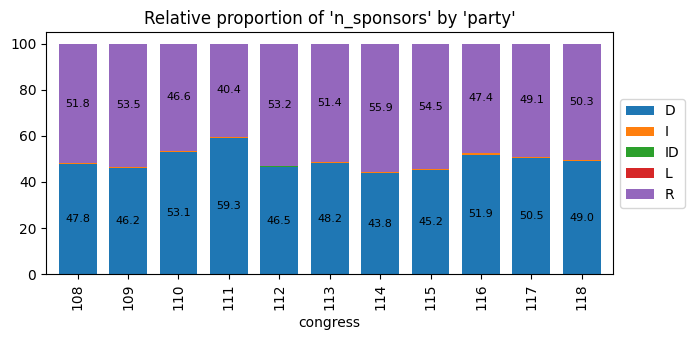

In [29]:
# Distribution of sponsors by party over time
tmp = (
    data.groupby(["congress", "party"])["sponsor_id"]
    .nunique()
    .reset_index(name="n_sponsors")
)

viz.plot_relative_proportion(tmp, x="congress", y="n_sponsors", hue="party")

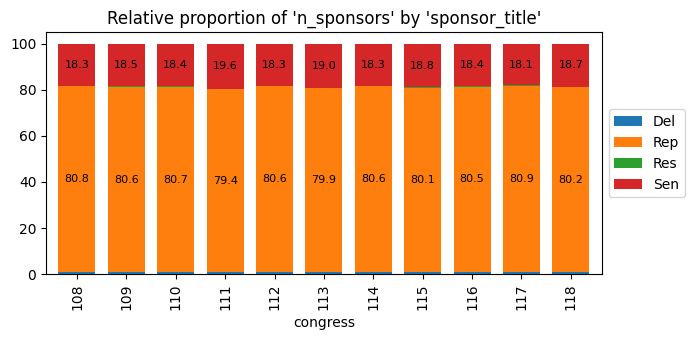

In [30]:
# Distribution of sponsors by title
tmp = (
    data.groupby(["congress", "sponsor_title"])["sponsor_id"]
    .nunique()
    .reset_index(name="n_sponsors")
)

viz.plot_relative_proportion(tmp, x="congress", y="n_sponsors", hue="sponsor_title")

- Sponsor composition is also stable over time
  - By party: `D` (50%), `R` (50%)
  - By title: `Rep` (81%), `Sen` (18%)


## Activities


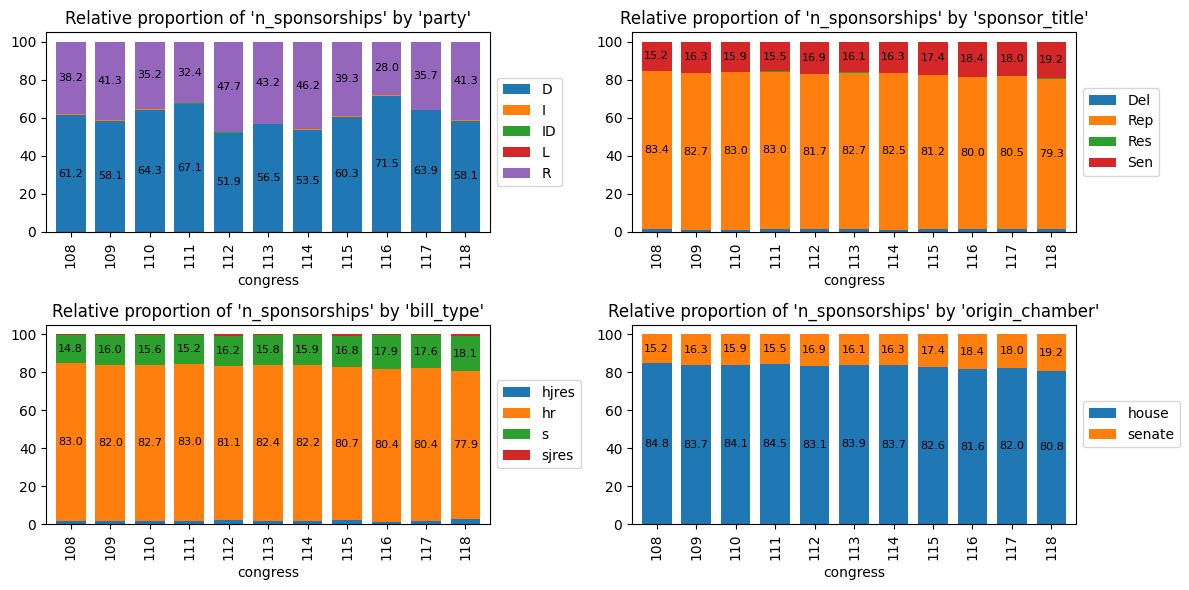

In [31]:
# Activities over time by different dimensions
cols = ["party", "sponsor_title", "bill_type", "origin_chamber"]
fig, axes = viz.create_plot_grid(len(cols), n_cols=2, cell_size=(6, 3))

for i, col in enumerate(cols):
    tmp = data.groupby(["congress", col]).size().reset_index(name="n_sponsorships")
    viz.plot_relative_proportion(
        tmp,
        x="congress",
        y="n_sponsorships",
        hue=col,
        ax=axes[i],
    )

plt.tight_layout()
plt.show()

- Composition of sponsorship activities is also relatively stable
  - However Democrats are more active in sponsoring bills
  - There is a gradual increase in the proportion of bills sponsored by senators (from 15% in 108th congress to 19% in 117th congress)


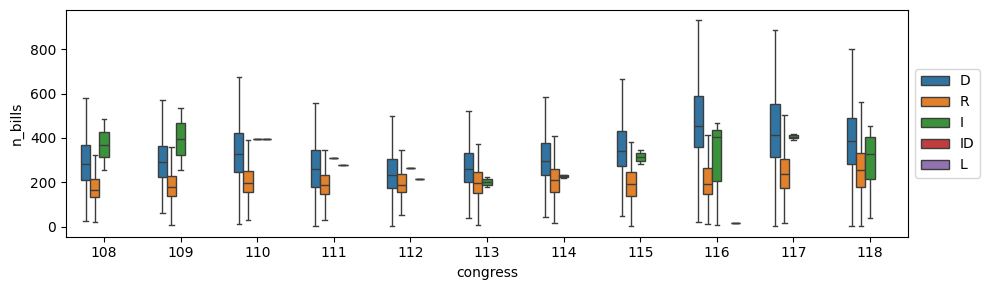

,count,mean,std,min,25%,50%,75%,max
party,,,,,,,,
D,2992.0,341.39,167.47,1.0,233.0,316.0,427.0,1902.0
I,22.0,310.32,135.01,9.0,240.0,294.5,402.0,536.0
ID,3.0,297.00,90.35,217.0,248.0,279.0,337.0,395.0
L,1.0,15.00,NaN,15.0,15.0,15.0,15.0,15.0
R,3059.0,209.82,99.29,1.0,149.0,197.0,256.5,1116.0


In [32]:
# Bills per sponsor by party (all)
tmp = (
    data.groupby(["congress", "sponsor_id", "party"])["bill_id"]
    .nunique()
    .reset_index(name="n_bills")
)

fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(
    data=tmp,
    x="congress",
    y="n_bills",
    hue="party",
    width=0.6,
    ax=ax,
    showfliers=False,
)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Summary statistics
tmp.groupby("party")["n_bills"].describe().round(2)

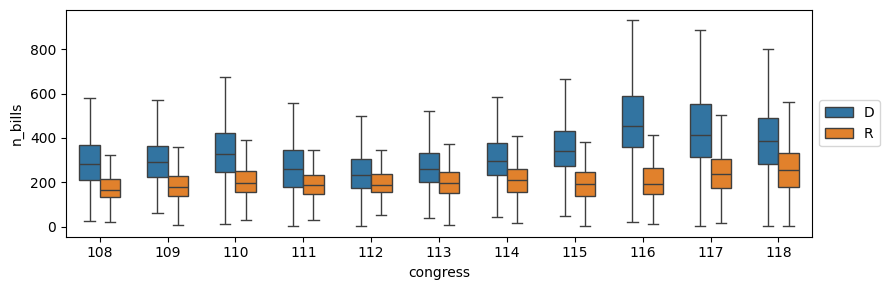

,count,mean,std,min,25%,50%,75%,max
party,,,,,,,,
D,2992.0,341.39,167.47,1.0,233.0,316.0,427.0,1902.0
R,3059.0,209.82,99.29,1.0,149.0,197.0,256.5,1116.0


In [33]:
# Bills per sponsor by party (D and R only)
tmp = (
    data[data["party"].isin(["R", "D"])]
    .groupby(["congress", "sponsor_id", "party"])["bill_id"]
    .nunique()
    .reset_index(name="n_bills")
)

fig, ax = plt.subplots(figsize=(9, 3))
sns.boxplot(
    data=tmp,
    x="congress",
    y="n_bills",
    hue="party",
    width=0.6,
    ax=ax,
    showfliers=False,
)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Summary statistics
tmp.groupby("party")["n_bills"].describe().round(2)

- There is a gradual increase in the number of bills per sponsor since 113th congress, mostly driven by Democrats (see boxplots)
- Democrats have significantly higher bills per sponsor than Republicans (see boxplots)


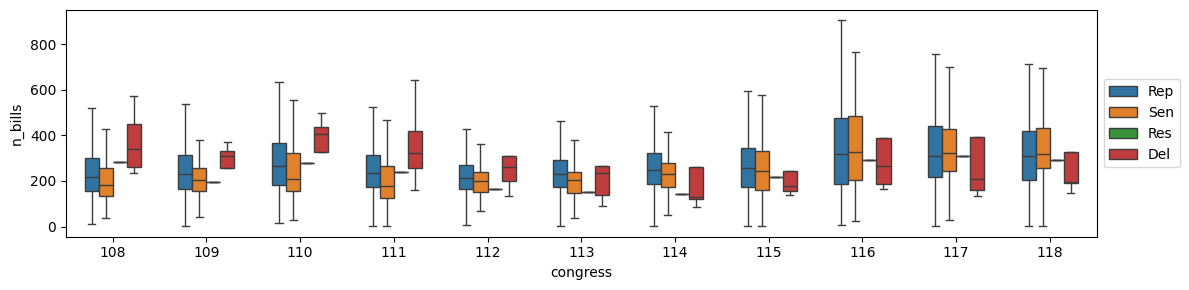

In [34]:
# Bills per sponsor by sponsor title
tmp = (
    data.groupby(["congress", "sponsor_id", "sponsor_title"])["bill_id"]
    .nunique()
    .reset_index(name="n_bills")
)

fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(
    data=tmp,
    x="congress",
    y="n_bills",
    hue="sponsor_title",
    width=0.6,
    ax=ax,
    showfliers=False,
)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

## Final check on data prep pipeline


In [35]:
# Load data using data_prep
df = data_prep.prepare_data()
dx.summarize_df(df)

Shape: (1671005, 18)


,bioguide_id,party,state,district,sponsor_type,congress,bill_type,bill_number,origin_chamber,policy_area,title,introduced_date,bill_id,sponsor_title,sponsor_id,first_name,last_name,display_name
0,Y000031,R,FL,10,sponsor,108,hjres,114,house,economics and public finance,Making further continuing appropriations for t...,2004-11-19,108_hjres_114,Rep,Y000031_R_FL_Rep,C. W.,Young,Rep. C. W. Young (R)


In [36]:
# Check sponsor duplicates
cols = ["bioguide_id", "party", "state", "sponsor_title", "display_name", "sponsor_id"]
s = df[cols].drop_duplicates().reset_index(drop=True)
dx.summarize_df(s)

Shape: (1428, 6)


,bioguide_id,party,state,sponsor_title,display_name,sponsor_id
0,Y000031,R,FL,Rep,Rep. C. W. Young (R),Y000031_R_FL_Rep


In [37]:
dup = s["bioguide_id"].value_counts()
dup = dup[dup > 1].index.tolist()
s[s["bioguide_id"].isin(dup)].sort_values("bioguide_id")

,bioguide_id,party,state,sponsor_title,display_name,sponsor_id
421,A000361,R,LA,Rep,Rep. Rodney Alexander (R),A000361_R_LA_Rep
290,A000361,D,LA,Rep,Rep. Rodney Alexander (D),A000361_D_LA_Rep
780,A000367,R,MI,Rep,Rep. Justin Amash (R),A000367_R_MI_Rep
1233,A000367,I,MI,Rep,Rep. Justin Amash (I),A000367_I_MI_Rep
1218,A000367,L,MI,Rep,Rep. Justin Amash (L),A000367_L_MI_Rep
874,B000575,R,MO,Sen,Sen. Roy Blunt (R),B000575_R_MO_Sen
287,B000575,R,MO,Rep,Rep. Roy Blunt (R),B000575_R_MO_Rep
365,B000944,D,OH,Rep,Rep. Sherrod Brown (D),B000944_D_OH_Rep
667,B000944,D,OH,Sen,Sen. Sherrod Brown (D),B000944_D_OH_Sen
278,B001135,R,NC,Rep,Rep. Richard Burr (R),B001135_R_NC_Rep
